In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Configure pandas options for better display
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Function to load dataset
def load_data(file_path: str) -> pd.DataFrame:
    """
    Load dataset from a given file path.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The loaded data as a pandas DataFrame.
    """
    return pd.read_csv(file_path)

In [3]:
# Load dataset
df = load_data('../data/raw/Customer_Data.csv')

# Standardize column names to lowercase
df.columns = map(str.lower, df.columns)

# Drop customer ID as it's not needed for analysis
if 'cust_id' in df.columns:
    df.drop('cust_id', axis=1, inplace=True)

In [4]:
# Display basic information about the dataset
print("Dataframe shape:", df.shape)
print("First 5 rows of the dataset:\n", df.head())
print("Dataset description:\n", df.describe())
print("Number of duplicate rows:", df.duplicated().sum())
print("Random sample of data (transposed):\n", df.sample(5).T)

Dataframe shape: (8950, 17)
First 5 rows of the dataset:
    balance  balance_frequency  purchases  oneoff_purchases  \
0    40.90               0.82      95.40              0.00   
1 3,202.47               0.91       0.00              0.00   
2 2,495.15               1.00     773.17            773.17   
3 1,666.67               0.64   1,499.00          1,499.00   
4   817.71               1.00      16.00             16.00   

   installments_purchases  cash_advance  purchases_frequency  \
0                   95.40          0.00                 0.17   
1                    0.00      6,442.95                 0.00   
2                    0.00          0.00                 1.00   
3                    0.00        205.79                 0.08   
4                    0.00          0.00                 0.08   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                        0.00                              0.08   
1                        0.00                     

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

Missing values:
 credit_limit          1
minimum_payments    313
dtype: int64


In [6]:
# Display random samples from key columns with missing data
print("Sample of minimum_payments:\n", df['minimum_payments'].sample(10))
print("Sample of credit_limit:\n", df['credit_limit'].sample(10))

Sample of minimum_payments:
 5935     245.42
7664        NaN
2380      29.58
2120   1,005.22
8871     151.70
5648     139.57
1552   1,543.18
8317   4,080.47
4559   2,569.38
2894   1,221.25
Name: minimum_payments, dtype: float64
Sample of credit_limit:
 3012    1,500.00
4413   10,500.00
6159    1,700.00
549     1,500.00
4830   12,000.00
3287   10,500.00
5804    7,500.00
8430    2,000.00
2900    1,800.00
4421    1,600.00
Name: credit_limit, dtype: float64


In [ ]:
# Impute missing values using the median for columns with missing data
columns_to_impute = ['minimum_payments', 'credit_limit']
imputer = SimpleImputer(strategy='median')
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
print("Missing values after imputation:\n", df[columns_to_impute].isnull().sum())


Missing values after imputation:
 minimum_payments    0
credit_limit        0
dtype: int64


In [8]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(df: pd.DataFrame, sample_limit: int = 3) -> pd.DataFrame:
    """
    Detects outliers in a DataFrame using the Interquartile Range (IQR) method.

    Args:
        df (pd.DataFrame): The input DataFrame.
        sample_limit (int, optional): Maximum number of outliers to sample per column. Defaults to 3.

    Returns:
        pd.DataFrame: Summary DataFrame of detected outliers for each numerical column.
    """
    outliers_summary = []
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1, Q3 = df[column].quantile(0.25), df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100
        # Collect statistics
        summary = {
            "Column": column,
            "Total Observations": len(df),
            "Number of Outliers": outlier_count,
            "Outlier Percentage (%)": round(outlier_percentage, 2),
            "Mean": round(df[column].mean(), 2),
            "Median": round(df[column].median(), 2),
            "Standard Deviation": round(df[column].std(), 2),
            "Skewness": round(df[column].skew(), 2),
            "Kurtosis": round(df[column].kurt(), 2),
            "Sample Outliers": outliers.head(sample_limit).to_dict(orient='records') if outlier_count > 0 else "None"
        }
        outliers_summary.append(summary)
    return pd.DataFrame(outliers_summary)

# Detect outliers in the dataset
outliers_summary_df = detect_outliers_iqr(df, sample_limit=3)

# Display outlier summary
print("Outlier Summary:")
print(outliers_summary_df)

Outlier Summary:
                              Column  Total Observations  Number of Outliers  \
0                            balance                8950                 695   
1                  balance_frequency                8950                1493   
2                          purchases                8950                 808   
3                   oneoff_purchases                8950                1013   
4             installments_purchases                8950                 867   
5                       cash_advance                8950                1030   
6                purchases_frequency                8950                   0   
7         oneoff_purchases_frequency                8950                 782   
8   purchases_installments_frequency                8950                   0   
9             cash_advance_frequency                8950                 525   
10                  cash_advance_trx                8950                 804   
11                     

In [9]:
# Function to treat outliers using capping method
def treat_outliers(df: pd.DataFrame, outliers_summary_df: pd.DataFrame, method: str = 'cap') -> pd.DataFrame:
    """
    Treat outliers by capping or removing them.

    Args:
        df (pd.DataFrame): The input DataFrame.
        outliers_summary_df (pd.DataFrame): Outlier summary DataFrame.
        method (str, optional): Method to treat outliers ('cap' or 'remove'). Defaults to 'cap'.

    Returns:
        pd.DataFrame: DataFrame with treated outliers.
    """
    df_cleaned = df.copy()
    for index, row in outliers_summary_df.iterrows():
        column = row['Column']
        Q1, Q3 = df[column].quantile(0.25), df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        if method == 'cap':
            # Cap outliers
            df_cleaned[column] = df_cleaned[column].clip(lower_bound, upper_bound)
        elif method == 'remove':
            # Remove rows with outliers
            outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
            df_cleaned.drop(outliers.index, inplace=True)
    return df_cleaned

# Treat outliers using the capping method
df_cleaned = treat_outliers(df, outliers_summary_df, method='cap')

# Display cleaned data
print("Cleaned Data (First 5 rows):\n", df_cleaned.head())

Cleaned Data (First 5 rows):
    balance  balance_frequency  purchases  oneoff_purchases  \
0    40.90               0.82      95.40              0.00   
1 3,202.47               0.91       0.00              0.00   
2 2,495.15               1.00     773.17            773.17   
3 1,666.67               0.72   1,499.00          1,443.51   
4   817.71               1.00      16.00             16.00   

   installments_purchases  cash_advance  purchases_frequency  \
0                   95.40          0.00                 0.17   
1                    0.00      2,784.55                 0.00   
2                    0.00          0.00                 1.00   
3                    0.00        205.79                 0.08   
4                    0.00          0.00                 0.08   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                        0.00                              0.08   
1                        0.00                              0.00   
2          

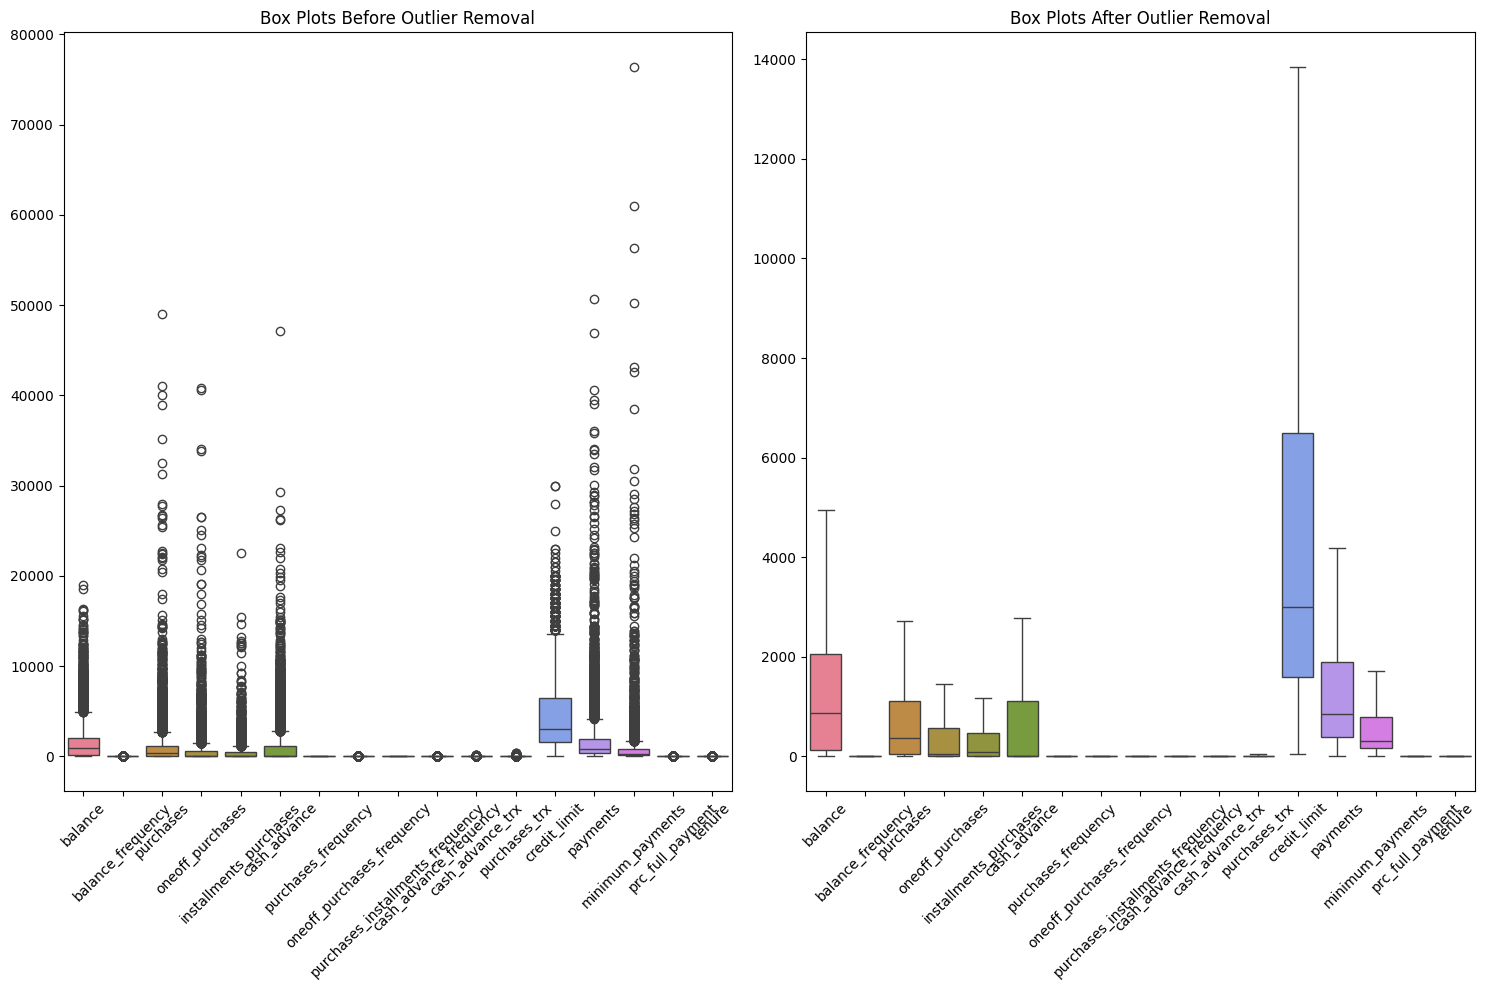

In [10]:
# Function to plot box plots before and after outlier treatment
def plot_boxplots_before_after(original_data: pd.DataFrame, cleaned_data: pd.DataFrame):
    """
    Plot box plots to compare original and cleaned datasets before and after outlier removal.
    
    Args:
        original_data (pd.DataFrame): The original DataFrame.
        cleaned_data (pd.DataFrame): The cleaned DataFrame after outlier removal.
    """
    # Get all numerical columns
    numerical_columns = original_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    plt.figure(figsize=(15, 10))

    # Original data box plots
    plt.subplot(1, 2, 1)
    sns.boxplot(data=original_data[numerical_columns])
    plt.title('Box Plots Before Outlier Removal')
    plt.xticks(rotation=45)

    # Cleaned data box plots
    plt.subplot(1, 2, 2)
    sns.boxplot(data=cleaned_data[numerical_columns])
    plt.title('Box Plots After Outlier Removal')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Plot box plots for all features
plot_boxplots_before_after(df, df_cleaned)

In [11]:
# Function to detect skewness and kurtosis
def detect_skewness_kurtosis(df: pd.DataFrame) -> pd.DataFrame:
    """
    Detect skewness and kurtosis for numerical columns in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A DataFrame summarizing skewness and kurtosis for each numerical column.
    """
    summary = []
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        summary.append({
            "Column": column,
            "Skewness": round(df[column].skew(), 2),
            "Kurtosis": round(df[column].kurt(), 2),
            "Mean": round(df[column].mean(), 2),
            "Median": round(df[column].median(), 2),
            "Standard Deviation": round(df[column].std(), 2)
        })
    return pd.DataFrame(summary)

# Detect skewness and kurtosis
skewness_kurtosis_summary_df = detect_skewness_kurtosis(df_cleaned)

# Display skewness and kurtosis summary
print("\nSkewness and Kurtosis Summary:")
print(skewness_kurtosis_summary_df)


Skewness and Kurtosis Summary:
                              Column  Skewness  Kurtosis     Mean   Median  \
0                            balance      1.17      0.20 1,390.51   873.39   
1                  balance_frequency     -1.17     -0.43     0.93     1.00   
2                          purchases      1.21      0.15   737.15   361.28   
3                   oneoff_purchases      1.24     -0.03   354.36    38.00   
4             installments_purchases      1.22      0.09   295.55    89.00   
5                       cash_advance      1.24     -0.04   672.47     0.00   
6                purchases_frequency      0.06     -1.64     0.49     0.50   
7         oneoff_purchases_frequency      1.25      0.12     0.18     0.08   
8   purchases_installments_frequency      0.51     -1.40     0.36     0.17   
9             cash_advance_frequency      1.27      0.42     0.13     0.00   
10                  cash_advance_trx      1.28      0.19     2.38     0.00   
11                     purchases

In [12]:
# Function to fix skewness and kurtosis
def fix_skewness_kurtosis(df: pd.DataFrame, summary_df: pd.DataFrame, skew_threshold: float = 0.5, kurt_threshold: float = 3) -> pd.DataFrame:
    """
    Fix skewness and kurtosis in the dataset using transformations.

    Args:
        df (pd.DataFrame): The input DataFrame.
        summary_df (pd.DataFrame): Summary DataFrame with skewness and kurtosis info.
        skew_threshold (float, optional): Threshold to decide skewness. Defaults to 0.5.
        kurt_threshold (float, optional): Threshold to decide kurtosis. Defaults to 3.

    Returns:
        pd.DataFrame: Transformed DataFrame with fixed skewness and kurtosis.
    """
    df_transformed = df.copy()
    for _, row in summary_df.iterrows():
        column = row['Column']
        skewness, kurtosis = row['Skewness'], row['Kurtosis']
        if skewness > skew_threshold:
            # Apply log transformation for positive skewness
            df_transformed[column] = np.log1p(df_transformed[column].clip(lower=0))
        elif skewness < -skew_threshold:
            # Apply square root transformation for negative skewness
            df_transformed[column] = np.sqrt(df_transformed[column].clip(lower=0))
        # Optionally handle kurtosis if needed (skipped here)
    return df_transformed


In [ ]:
# Fix skewness in the dataset
df_fixed_skewness = fix_skewness_kurtosis(df_cleaned, skewness_kurtosis_summary_df)

# Display transformed data
print("\nTransformed Data (First 5 rows):\n", df_fixed_skewness.head())


Transformed Data (First 5 rows):
    balance  balance_frequency  purchases  oneoff_purchases  \
0     3.74               0.90       4.57              0.00   
1     8.07               0.95       0.00              0.00   
2     7.82               1.00       6.65              6.65   
3     7.42               0.85       7.31              7.28   
4     6.71               1.00       2.83              2.83   

   installments_purchases  cash_advance  purchases_frequency  \
0                    4.57          0.00                 0.17   
1                    0.00          7.93                 0.00   
2                    0.00          0.00                 1.00   
3                    0.00          5.33                 0.08   
4                    0.00          0.00                 0.08   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                        0.00                              0.08   
1                        0.00                              0.00   
2     

In [14]:
# Plot skewness before and after fixing
def plot_skewness_comparison(original_summary: pd.DataFrame, fixed_summary: pd.DataFrame):
    """
    Plot comparison of skewness before and after fixing.

    Args:
        original_summary (pd.DataFrame): Summary before fixing.
        fixed_summary (pd.DataFrame): Summary after fixing.
    """
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(original_summary))  # Get the range of indices for x-axis

    # Plot the skewness before fixing
    plt.bar(index, original_summary['skewness'], bar_width, label='Before Fixing', alpha=0.7)

    # Plot the skewness after fixing
    plt.bar(index + bar_width, fixed_summary['skewness'], bar_width, label='After Fixing', alpha=0.7)

    # Labels and title
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Skewness', fontsize=12)
    plt.title('Comparison of Skewness Before and After Fixing', fontsize=15)
    plt.xticks(index + bar_width / 2, original_summary.index, rotation=90)  # Feature names on x-axis
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

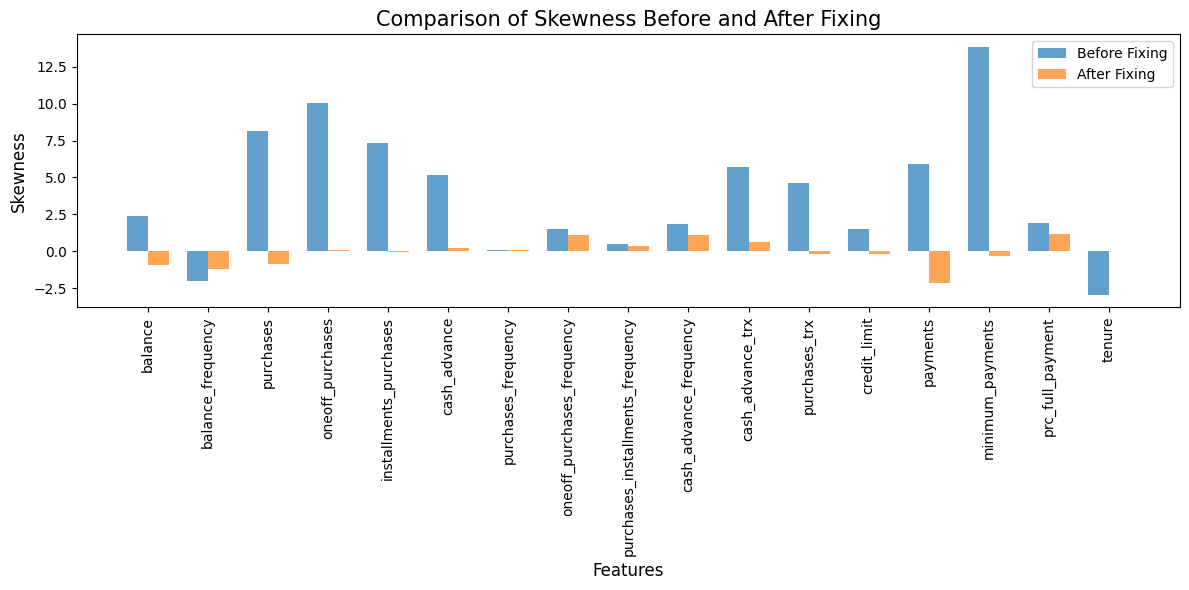

In [15]:
#  before and after summary
original_summary = df.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
fixed_summary = df_fixed_skewness.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# Adding skewness to summaries
original_summary['skewness'] = df.skew()
fixed_summary['skewness'] = df_fixed_skewness.skew()

# Plot the comparison
plot_skewness_comparison(original_summary, fixed_summary)

In [16]:
import os

# Optional: Save the cleaned and transformed dataset to a new CSV file
def save_cleaned_data(df: pd.DataFrame, file_path: str):
    """
    Save the cleaned and transformed dataset to a CSV file.

    Args:
        df (pd.DataFrame): The input DataFrame.
        file_path (str): The path where the CSV will be saved.
    """
    # Ensure that the directory exists
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Save the DataFrame to CSV
    df.to_csv(file_path, index=False)
    print(f"Cleaned data saved to {file_path}")

# Save the final cleaned dataset
save_cleaned_data(df_fixed_skewness, '../data/processed/Cleaned_Customer_Data.csv')



Cleaned data saved to ../data/processed/Cleaned_Customer_Data.csv


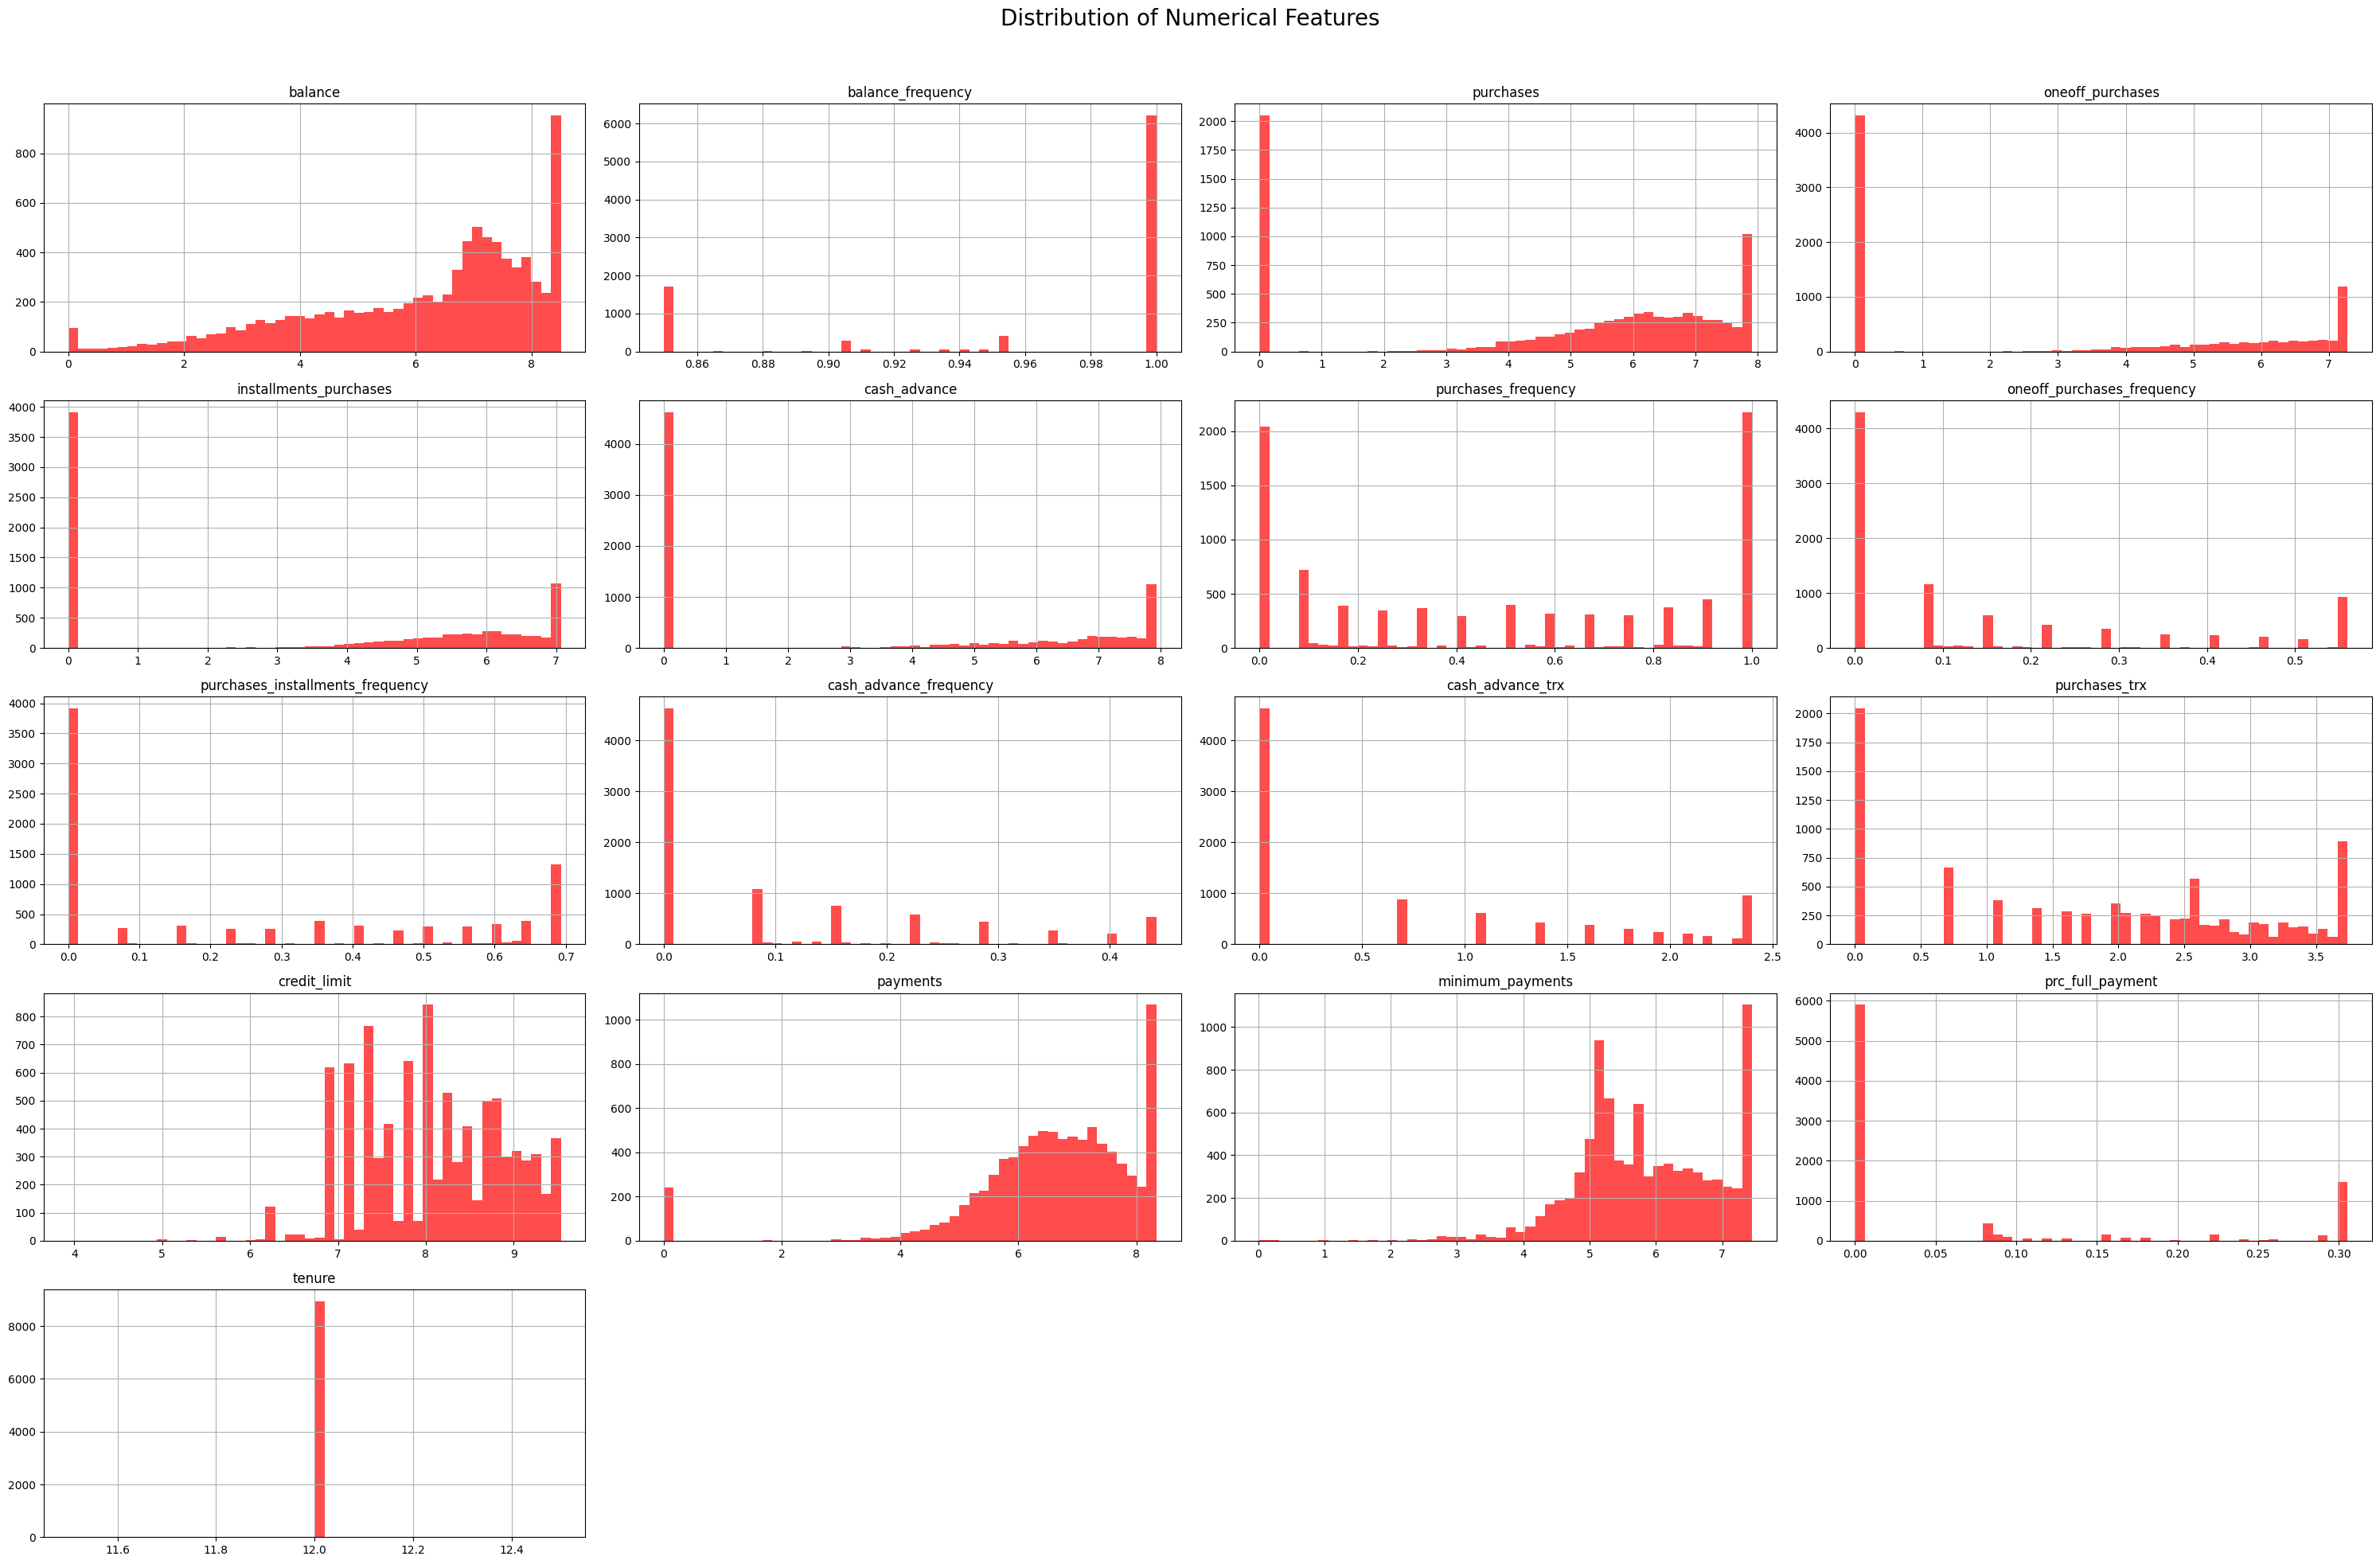

In [17]:
import matplotlib.pyplot as plt

# Distribution plot to visualize data distribution
def plot_all_feature_distributions(df: pd.DataFrame):
    """
    Plot histograms for the distributions of each numerical feature in the DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame with cleaned data.
    """
    # Plot histograms for all numerical columns in the DataFrame
    hist_plot = df.hist(bins=50, figsize=(30, 20), grid=True, color='red', alpha=0.7)

    # Set title for the overall plot
    plt.suptitle('Distribution of Numerical Features', fontsize=20)
    plt.xlabel('Value', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent overlap with suptitle
    plt.show()

# Call the function to plot distributions for cleaned data
plot_all_feature_distributions(df_fixed_skewness)


In [18]:
df_fixed_skewness.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,3.74,0.90,4.57,0.00,4.57,0.00,0.17,0.00,0.08,0.00,0.00,1.10,6.91,5.31,4.95,0.00,12
1,8.07,0.95,0.00,0.00,0.00,7.93,0.00,0.00,0.00,0.22,1.61,0.00,8.85,8.32,6.98,0.20,12
2,7.82,1.00,6.65,6.65,0.00,0.00,1.00,0.56,0.00,0.00,0.00,2.56,8.92,6.43,6.44,0.00,12
3,7.42,0.85,7.31,7.28,0.00,5.33,0.08,0.08,0.00,0.08,0.69,0.69,8.92,0.00,5.75,0.00,12
4,6.71,1.00,2.83,2.83,0.00,0.00,0.08,0.08,0.00,0.00,0.00,0.69,7.09,6.52,5.50,0.00,12


MODELING

In [19]:
# creating new variable for modeling
df_model = df_fixed_skewness.copy()

In [20]:
import pandas as pd
import numpy as np

def summary_stats(df_model, n=4):
    """
    Generate detailed descriptive statistics for the given DataFrame.

    Parameters:
    df_model (pd.DataFrame): The DataFrame for which to calculate statistics.
    n (int): Number of decimal places to round to.

    Returns:
    pd.DataFrame: A DataFrame containing descriptive statistics for each attribute.
    """
    
    # Calculate central tendency
    mean = pd.DataFrame(df_model.apply(np.mean)).T
    median = pd.DataFrame(df_model.apply(np.median)).T
    
    # Calculate distribution statistics
    std = pd.DataFrame(df_model.apply(np.std)).T
    min_value = pd.DataFrame(df_model.apply(np.min)).T
    max_value = pd.DataFrame(df_model.apply(np.max)).T
    range_value = pd.DataFrame(df_model.apply(lambda x: x.max() - x.min())).T
    skewness = pd.DataFrame(df_model.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(df_model.apply(lambda x: x.kurtosis())).T
    count = pd.DataFrame(df_model.count()).T  # Count of non-null values
    
    # Concatenate all statistics into a single DataFrame
    summary_stats = pd.concat([count, min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
    summary_stats.columns = ['Attributes', 'Count', 'Min', 'Max', 'Range', 'Mean', 'Median', 'Std Dev', 'Skewness', 'Kurtosis']
    
    # Format the DataFrame for better readability
    summary_stats['Min'] = summary_stats['Min'].round(n)
    summary_stats['Max'] = summary_stats['Max'].round(n)
    summary_stats['Range'] = summary_stats['Range'].round(n)
    summary_stats['Mean'] = summary_stats['Mean'].round(n)
    summary_stats['Median'] = summary_stats['Median'].round(n)
    summary_stats['Std Dev'] = summary_stats['Std Dev'].round(n)
    summary_stats['Skewness'] = summary_stats['Skewness'].round(n)
    summary_stats['Kurtosis'] = summary_stats['Kurtosis'].round(n)

    # Add a summary section title
    print("Summary Statistics:")
    
    return summary_stats

# descriptive analytic for modeling feature
summary_stats(df_model)


Summary Statistics:


,Attributes,Count,Min,Max,Range,Mean,Median,Std Dev,Skewness,Kurtosis
0,balance,"8,950.00",0.00,8.51,8.51,6.14,6.77,1.98,-0.94,0.22
1,balance_frequency,"8,950.00",0.85,1.00,0.15,0.96,1.00,0.06,-1.19,-0.39
2,purchases,"8,950.00",0.00,7.91,7.91,4.85,5.89,2.85,-0.85,-0.82
3,oneoff_purchases,"8,950.00",0.00,7.28,7.28,3.13,3.66,3.13,0.12,-1.81
4,installments_purchases,"8,950.00",0.00,7.07,7.07,3.30,4.50,3.01,-0.08,-1.82
5,cash_advance,"8,950.00",0.00,7.93,7.93,3.26,0.00,3.47,0.22,-1.81
6,purchases_frequency,"8,950.00",0.00,1.00,1.00,0.49,0.50,0.40,0.06,-1.64
7,oneoff_purchases_frequency,"8,950.00",0.00,0.56,0.56,0.15,0.08,0.20,1.09,-0.27
8,purchases_installments_frequency,"8,950.00",0.00,0.69,0.69,0.27,0.15,0.28,0.37,-1.55
9,cash_advance_frequency,"8,950.00",0.00,0.44,0.44,0.11,0.00,0.14,1.11,-0.04


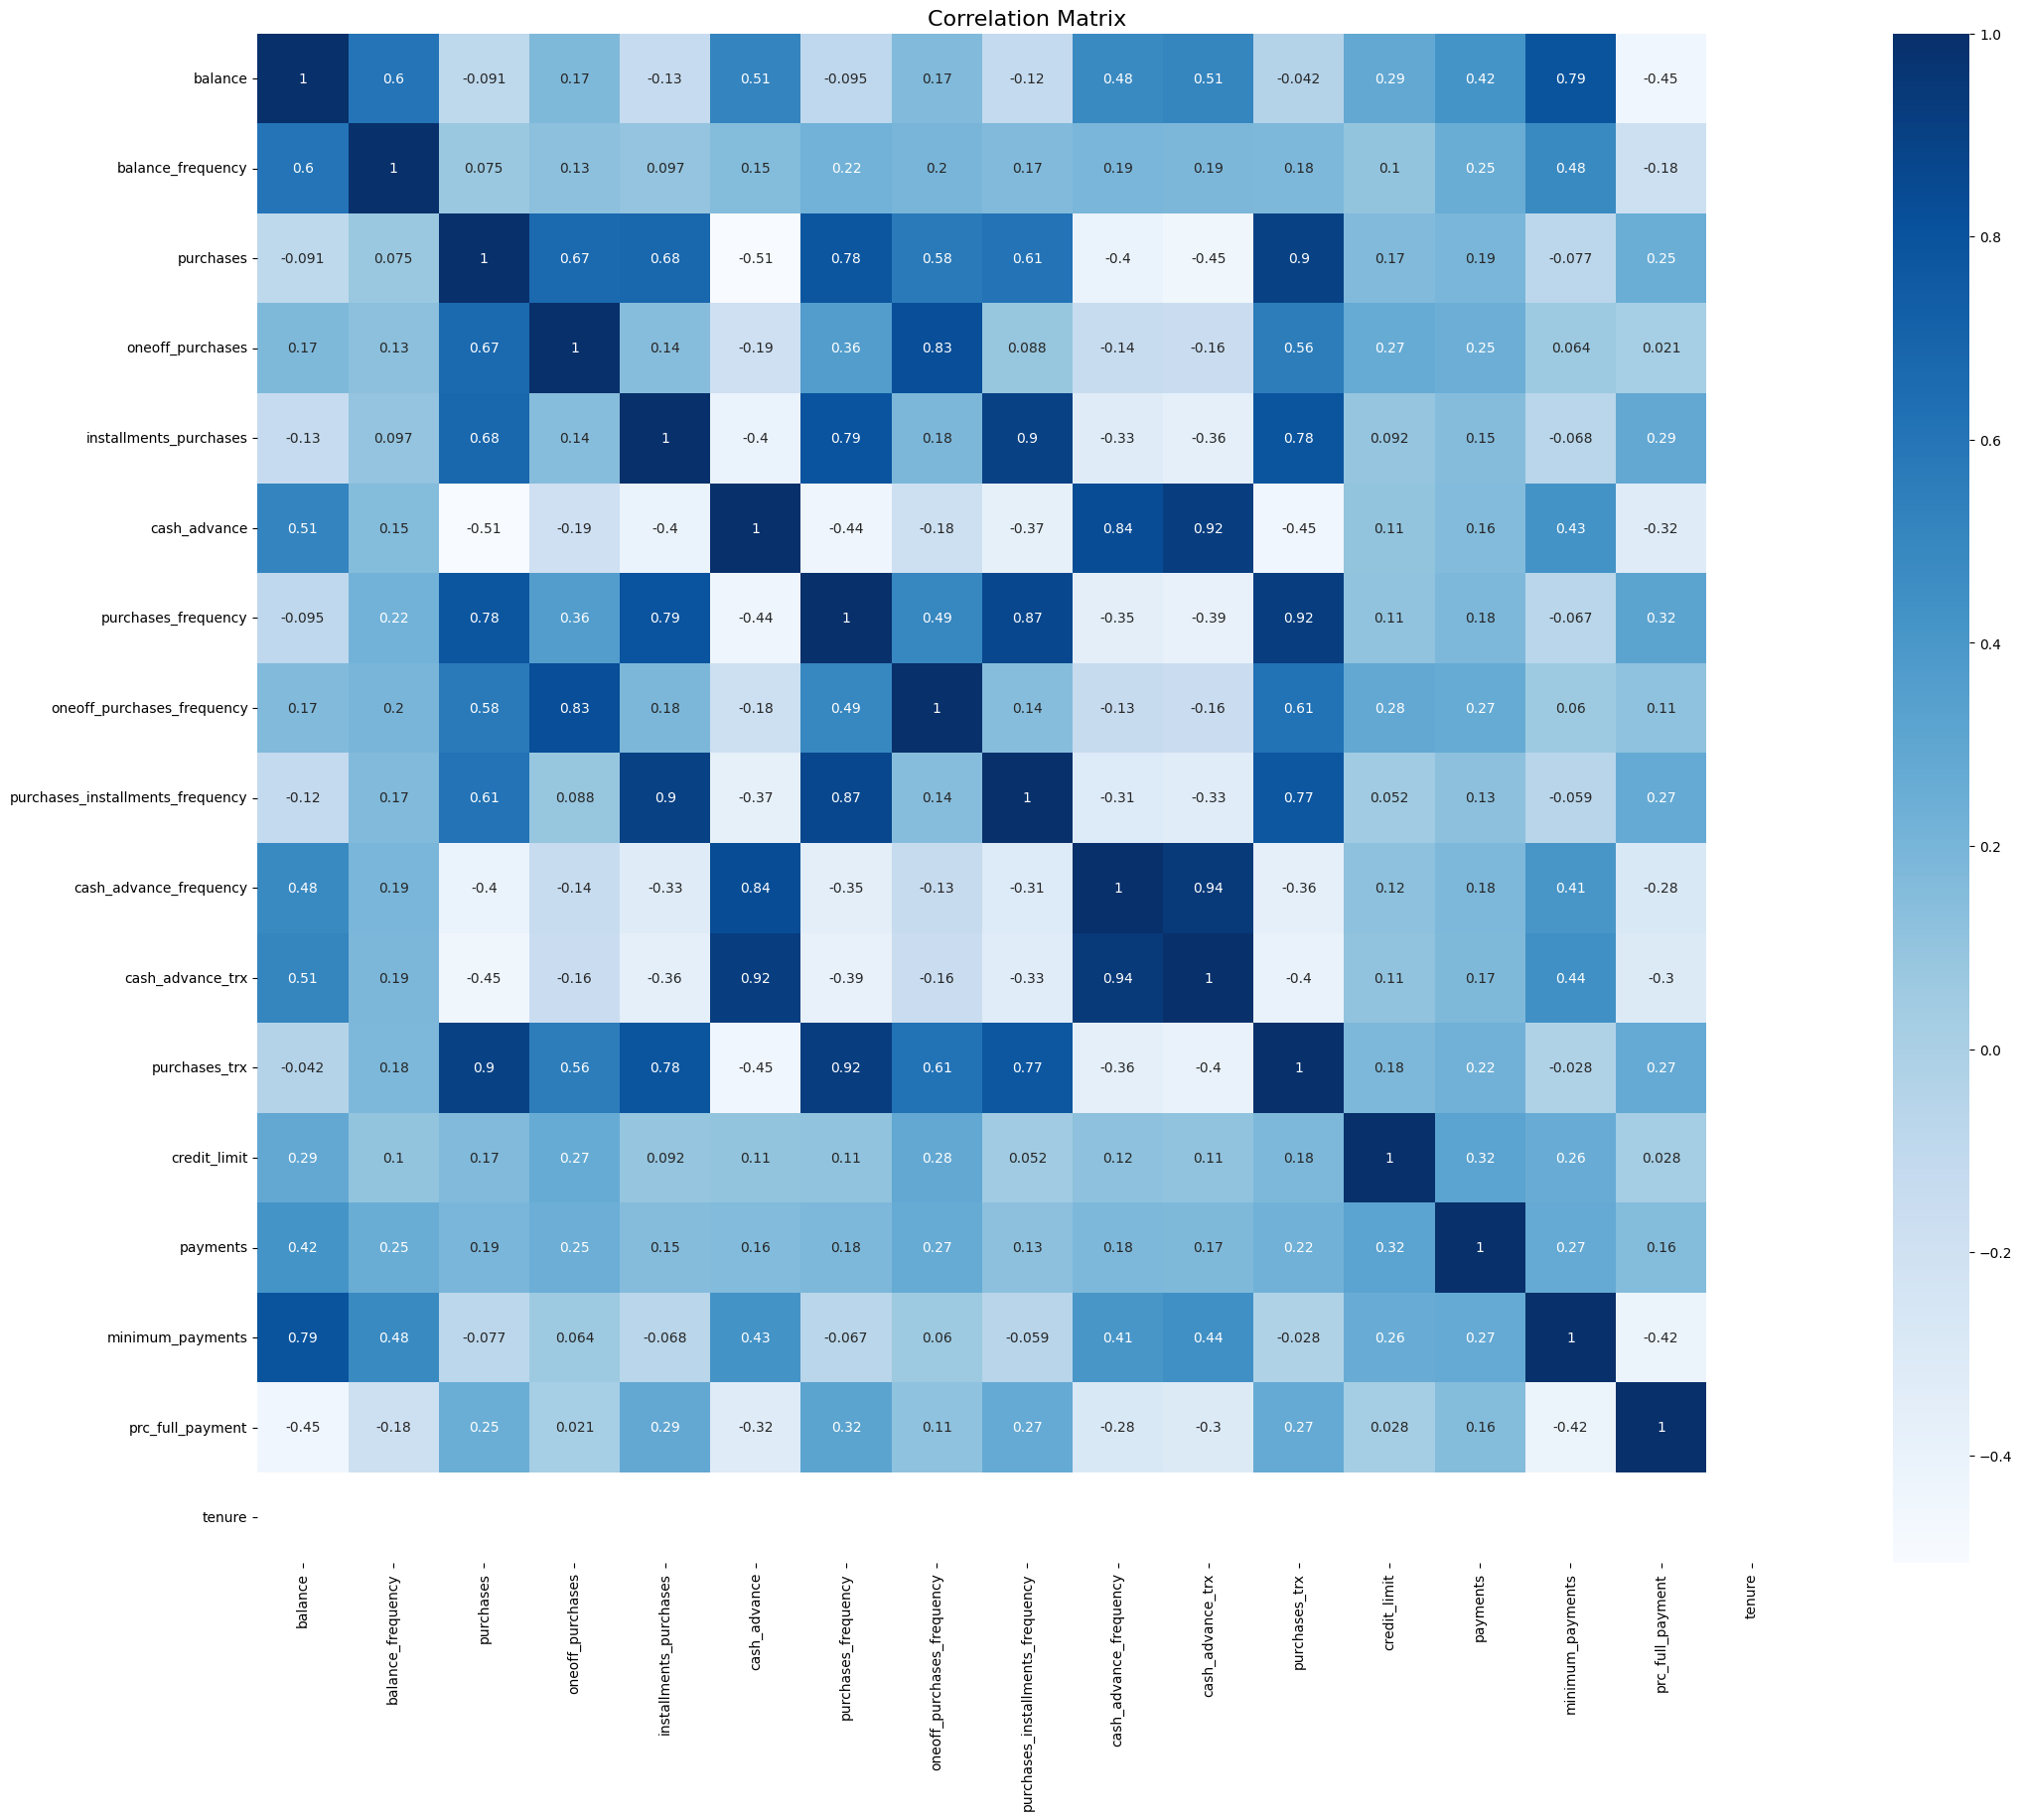

In [21]:
# Step 6: Correlation Matrix and Visualization
correlations = df_model.corr()
plt.figure(figsize=(25, 20))
sns.heatmap(correlations, annot=True, cmap="Blues")
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [22]:
import pandas as pd

# Assuming df is your DataFrame containing the relevant features
correlations = df_model.corr()

# 1. Set the diagonal to NaN to avoid considering self-correlation
correlation_matrix_no_diag = correlations.where(~np.eye(correlations.shape[0], dtype=bool))

# 2. Find the maximum correlation value and its corresponding feature pair
max_corr_value = correlation_matrix_no_diag.max().max()  # Find the maximum correlation value
max_corr_indices = correlation_matrix_no_diag.stack().idxmax()  # Find the corresponding feature pair

# 3. Find the minimum correlation value and its corresponding feature pair
min_corr_value = correlation_matrix_no_diag.min().min()  # Find the minimum correlation value
min_corr_indices = correlation_matrix_no_diag.stack().idxmin()  # Find the corresponding feature pair

# 4. Display the results
print(f"Maximum correlation value: {max_corr_value} between features: {max_corr_indices}")
print(f"Minimum correlation value: {min_corr_value} between features: {min_corr_indices}")


Maximum correlation value: 0.9420336366437173 between features: ('cash_advance_frequency', 'cash_advance_trx')
Minimum correlation value: -0.50530236287857 between features: ('purchases', 'cash_advance')


In [ ]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame containing the relevant features
correlations = df_model.corr()

# 1. Set the diagonal to NaN to avoid considering self-correlation
correlation_matrix_no_diag = correlations.where(~np.eye(correlations.shape[0], dtype=bool))

# Define correlation thresholds
positive_threshold = 0.7  # Adjust this based on your needs
negative_threshold = 0.5  # Adjust this based on your needs

# 2. Find positive correlations exceeding the threshold
positive_corr_pairs = correlation_matrix_no_diag.stack()[
    correlation_matrix_no_diag.stack() > positive_threshold
].reset_index()

positive_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
print("Positive correlation pairs (correlation > 0.5):")
print(positive_corr_pairs)

# 3. Find negative correlations below the threshold
negative_corr_pairs = correlation_matrix_no_diag.stack()[
    correlation_matrix_no_diag.stack() < negative_threshold
].reset_index()

negative_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
print("\nNegative correlation pairs (correlation < -0.5):")
print(negative_corr_pairs)

# 4. Display the maximum and minimum correlation values and their corresponding feature pairs again for context
max_corr_value = correlation_matrix_no_diag.max().max()
max_corr_indices = correlation_matrix_no_diag.stack().idxmax()

min_corr_value = correlation_matrix_no_diag.min().min()
min_corr_indices = correlation_matrix_no_diag.stack().idxmin()

print(f"\nMaximum correlation value: {max_corr_value} between features: {max_corr_indices}")
print(f"Minimum correlation value: {min_corr_value} between features: {min_corr_indices}")


Positive correlation pairs (correlation > 0.5):
                           Feature 1                         Feature 2  \
0                            balance                  minimum_payments   
1                          purchases               purchases_frequency   
2                          purchases                     purchases_trx   
3                   oneoff_purchases        oneoff_purchases_frequency   
4             installments_purchases               purchases_frequency   
5             installments_purchases  purchases_installments_frequency   
6             installments_purchases                     purchases_trx   
7                       cash_advance            cash_advance_frequency   
8                       cash_advance                  cash_advance_trx   
9                purchases_frequency                         purchases   
10               purchases_frequency            installments_purchases   
11               purchases_frequency  purchases_installments_fre

In [24]:
features_to_drop = [
    'purchases_frequency',
    'oneoff_purchases_frequency',
    'purchases_trx',
    'cash_advance_trx',
    'purchases_installments_frequency'
]

# Dropping features from df_model_features
df_model_features = df_model.drop(columns=features_to_drop)

df_model_features.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,cash_advance_frequency,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,3.74,0.90,4.57,0.00,4.57,0.00,0.00,6.91,5.31,4.95,0.00,12
1,8.07,0.95,0.00,0.00,0.00,7.93,0.22,8.85,8.32,6.98,0.20,12
2,7.82,1.00,6.65,6.65,0.00,0.00,0.00,8.92,6.43,6.44,0.00,12
3,7.42,0.85,7.31,7.28,0.00,5.33,0.08,8.92,0.00,5.75,0.00,12
4,6.71,1.00,2.83,2.83,0.00,0.00,0.00,7.09,6.52,5.50,0.00,12


In [25]:
df_model_features.dtypes, df_model_features.shape

(balance                   float64
 balance_frequency         float64
 purchases                 float64
 oneoff_purchases          float64
 installments_purchases    float64
 cash_advance              float64
 cash_advance_frequency    float64
 credit_limit              float64
 payments                  float64
 minimum_payments          float64
 prc_full_payment          float64
 tenure                      int64
 dtype: object,
 (8950, 12))

In [ ]:
df_model_features.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,cash_advance_frequency,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,3.74,0.90,4.57,0.00,4.57,0.00,0.00,6.91,5.31,4.95,0.00,12
1,8.07,0.95,0.00,0.00,0.00,7.93,0.22,8.85,8.32,6.98,0.20,12
2,7.82,1.00,6.65,6.65,0.00,0.00,0.00,8.92,6.43,6.44,0.00,12
3,7.42,0.85,7.31,7.28,0.00,5.33,0.08,8.92,0.00,5.75,0.00,12
4,6.71,1.00,2.83,2.83,0.00,0.00,0.00,7.09,6.52,5.50,0.00,12


In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [28]:
# Feature Engineering

# Create New Features
df_model_features['purchase_to_payment_ratio'] = df_model_features['purchases'] / (df_model_features['payments'] + 1e-5)
df_model_features['credit_utilization'] = df_model_features['balance'] / (df_model_features['credit_limit'] + 1e-5)
df_model_features['avg_purchases_per_month'] = df_model_features['purchases'] / df_model_features['tenure']
df_model_features['avg_payments_per_month'] = df_model_features['payments'] / df_model_features['tenure']
df_model_features['purchase_payment_interaction'] = df_model_features['purchases'] * df_model_features['payments']


In [ ]:
df_model_features.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,cash_advance_frequency,credit_limit,payments,minimum_payments,prc_full_payment,tenure,purchase_to_payment_ratio,credit_utilization,avg_purchases_per_month,avg_payments_per_month,purchase_payment_interaction
0,3.74,0.90,4.57,0.00,4.57,0.00,0.00,6.91,5.31,4.95,0.00,12,0.86,0.54,0.38,0.44,24.27
1,8.07,0.95,0.00,0.00,0.00,7.93,0.22,8.85,8.32,6.98,0.20,12,0.00,0.91,0.00,0.69,0.00
2,7.82,1.00,6.65,6.65,0.00,0.00,0.00,8.92,6.43,6.44,0.00,12,1.03,0.88,0.55,0.54,42.80
3,7.42,0.85,7.31,7.28,0.00,5.33,0.08,8.92,0.00,5.75,0.00,12,"731,322.04",0.83,0.61,0.00,0.00
4,6.71,1.00,2.83,2.83,0.00,0.00,0.00,7.09,6.52,5.50,0.00,12,0.43,0.95,0.24,0.54,18.48


In [30]:
df_model_features.shape

(8950, 17)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df_model_features is your DataFrame
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_model_features)

# Create a DataFrame from the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=df_model_features.columns)

# Display the first few rows of the scaled DataFrame
scaled_df.head()


,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,cash_advance_frequency,credit_limit,payments,minimum_payments,prc_full_payment,tenure,purchase_to_payment_ratio,credit_utilization,avg_purchases_per_month,avg_payments_per_month,purchase_payment_interaction
0,-1.21,-0.98,-0.10,-1.00,0.42,-0.94,-0.76,-1.46,-0.83,-0.87,-0.64,0.00,-0.13,-0.92,-0.10,-0.83,-0.38
1,0.98,-0.17,-1.70,-1.00,-1.10,1.35,0.81,0.94,1.15,1.09,1.04,0.00,-0.13,0.64,-1.70,1.15,-1.49
2,0.85,0.61,0.63,1.12,-1.10,-0.94,-0.76,1.03,-0.09,0.57,-0.64,0.00,-0.13,0.50,0.63,-0.09,0.46
3,0.65,-1.90,0.86,1.32,-1.10,0.60,-0.20,1.03,-4.33,-0.10,-0.64,0.00,9.36,0.31,0.86,-4.33,-1.49
4,0.29,0.61,-0.71,-0.09,-1.10,-0.94,-0.76,-1.23,-0.03,-0.33,-0.64,0.00,-0.13,0.79,-0.71,-0.03,-0.65


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import scipy.cluster.hierarchy as sch

# Set style for seaborn
sns.set(style="whitegrid")


In [33]:
# Load your scaled DataFrame
# Example: scaled_df = pd.read_csv('path_to_your_scaled_data.csv')

# Display basic information about the data
print(scaled_df.info())
print(scaled_df.describe())

# Check for missing values
print(scaled_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   balance                       8950 non-null   float64
 1   balance_frequency             8950 non-null   float64
 2   purchases                     8950 non-null   float64
 3   oneoff_purchases              8950 non-null   float64
 4   installments_purchases        8950 non-null   float64
 5   cash_advance                  8950 non-null   float64
 6   cash_advance_frequency        8950 non-null   float64
 7   credit_limit                  8950 non-null   float64
 8   payments                      8950 non-null   float64
 9   minimum_payments              8950 non-null   float64
 10  prc_full_payment              8950 non-null   float64
 11  tenure                        8950 non-null   float64
 12  purchase_to_payment_ratio     8950 non-null   float64
 13  cre

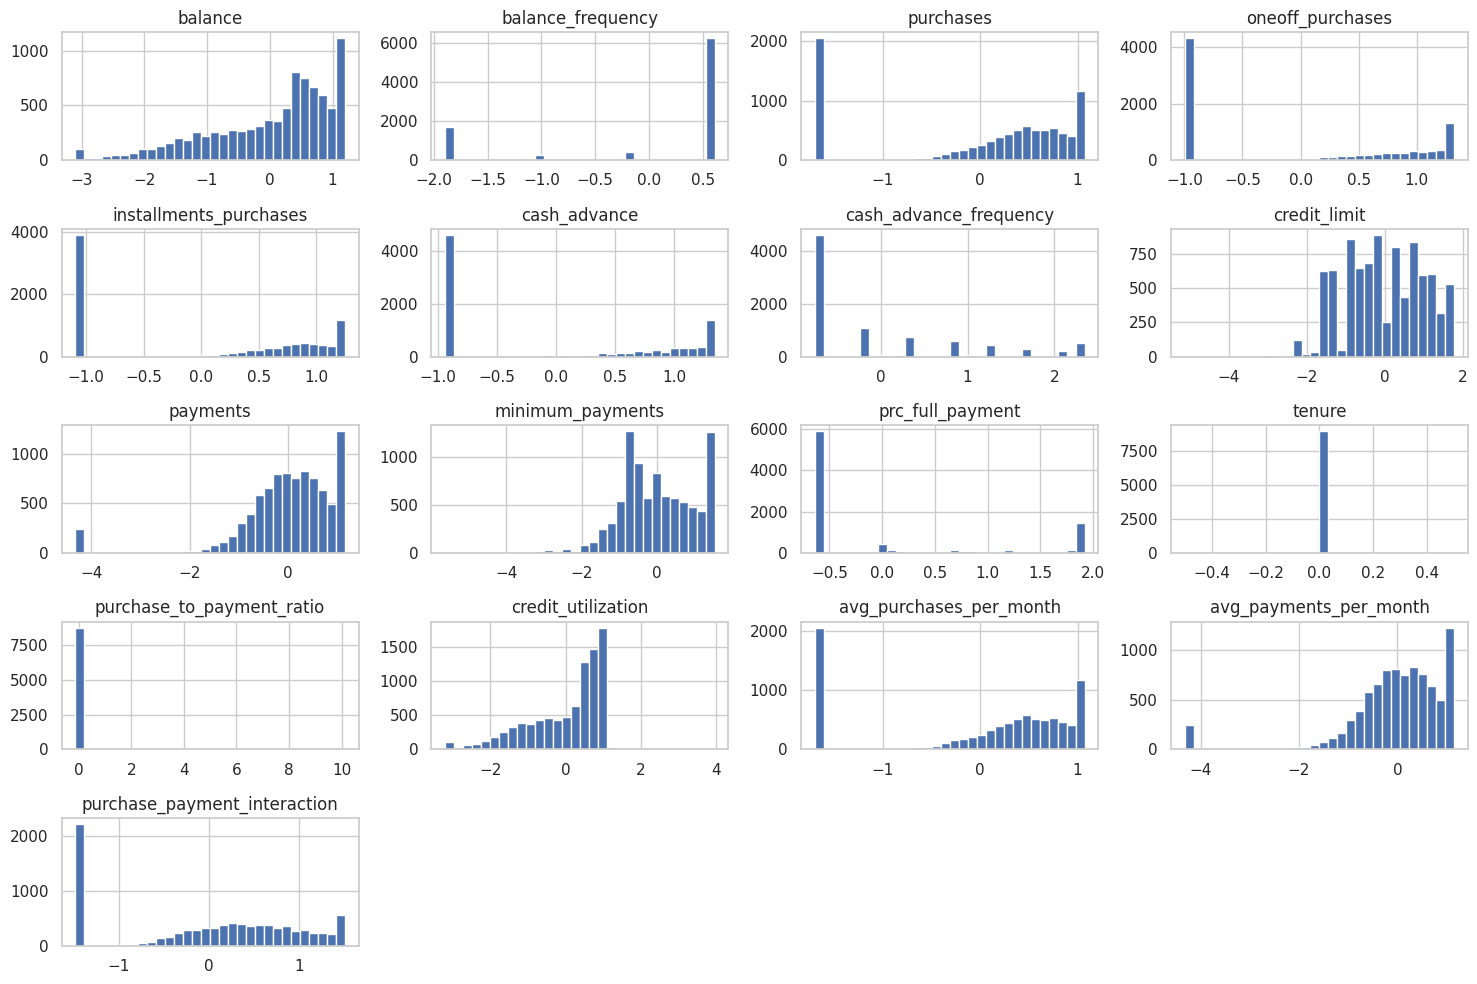

In [34]:
# Plotting histograms for each feature
scaled_df.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()


In [35]:
# # Create a pair plot for the scaled DataFrame
# plt.figure(figsize=(12, 10))
# sns.pairplot(scaled_df)
# plt.suptitle('Pair Plot of Scaled DataFrame', y=1.02)  # Adjust title position
# plt.show()


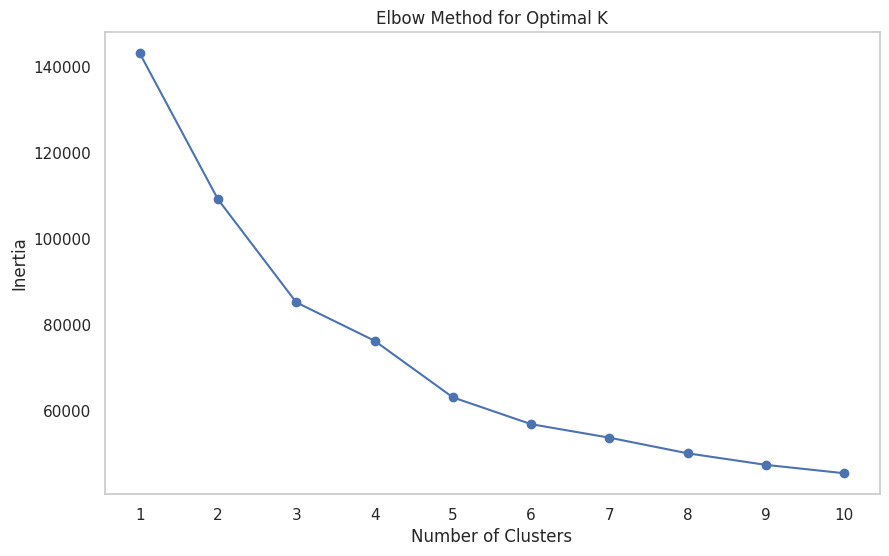

In [36]:
# Elbow Method to find optimal number of clusters
inertia = []
range_n_clusters = range(1, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range_n_clusters)
plt.grid()
plt.show()


In [37]:
# Fit K-Means with the chosen number of clusters (e.g., from elbow method)
optimal_clusters_kmeans = 4  # Adjust based on elbow method
kmeans = KMeans(n_clusters=optimal_clusters_kmeans, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_df)

# Add cluster labels to the DataFrame
scaled_df['KMeans_Cluster'] = kmeans_labels


In [38]:
# Define linkage methods
linkage_methods = ['ward', 'average', 'complete']
agglomerative_results = {}

for method in linkage_methods:
    # Fit Agglomerative Clustering with the optimal number of clusters
    agglomerative = AgglomerativeClustering(n_clusters=optimal_clusters_kmeans, linkage=method)
    agglomerative_labels = agglomerative.fit_predict(scaled_df)

    # Store results
    agglomerative_results[method] = agglomerative_labels

    # Add cluster labels to the DataFrame
    scaled_df[f'Agglomerative_Cluster_{method}'] = agglomerative_labels


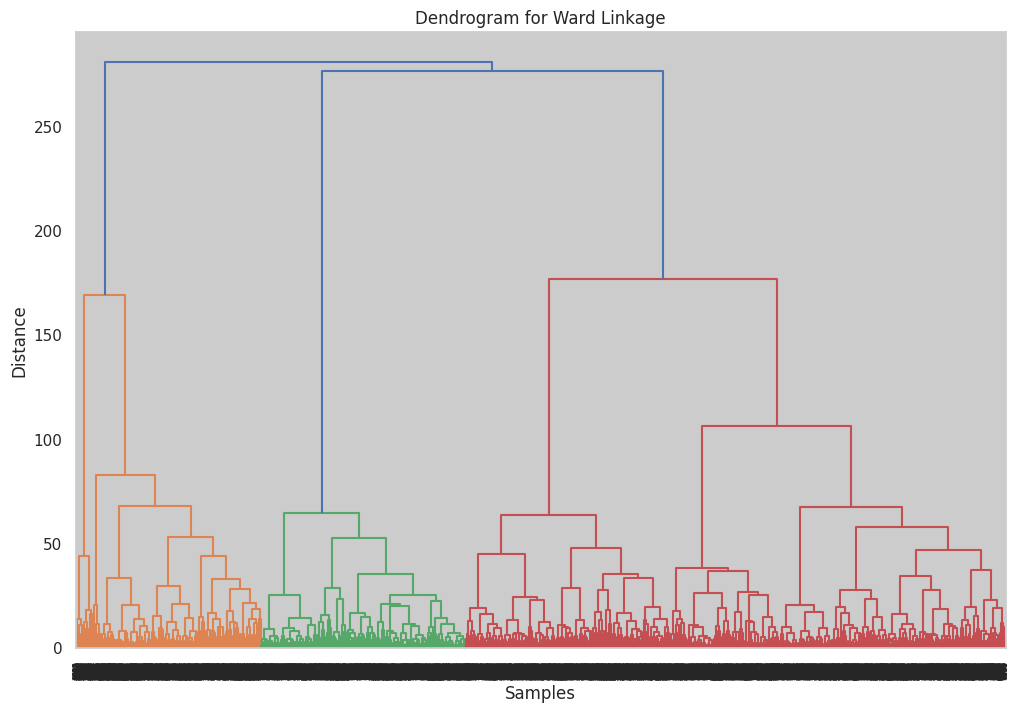

In [39]:
# Dendrogram for Ward method
plt.figure(figsize=(12, 8))
dendrogram = sch.dendrogram(sch.linkage(scaled_df, method='ward'))
plt.title('Dendrogram for Ward Linkage')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


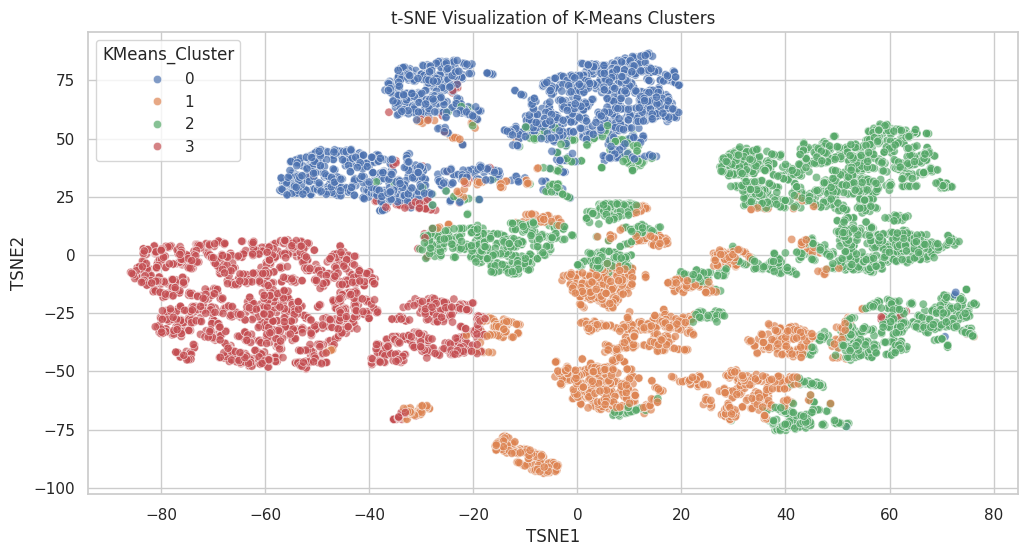

In [40]:
# Perform t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_df.drop(columns=['KMeans_Cluster'] + [f'Agglomerative_Cluster_{m}' for m in linkage_methods]))

# Create a new DataFrame for visualization
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['KMeans_Cluster'] = kmeans_labels

# Plotting t-SNE results for K-Means
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='KMeans_Cluster', data=tsne_df, palette='deep', legend='full', alpha=0.7)
plt.title('t-SNE Visualization of K-Means Clusters')
plt.show()


In [41]:
# Calculate silhouette scores for K-Means
kmeans_silhouette = silhouette_score(scaled_df, kmeans_labels)
print(f'K-Means Silhouette Score: {kmeans_silhouette:.4f}')

# Calculate silhouette scores for Agglomerative Clustering
for method in linkage_methods:
    silhouette = silhouette_score(scaled_df, agglomerative_results[method])
    print(f'Agglomerative Clustering ({method}) Silhouette Score: {silhouette:.4f}')


K-Means Silhouette Score: 0.3238
Agglomerative Clustering (ward) Silhouette Score: 0.3266
Agglomerative Clustering (average) Silhouette Score: 0.3406
Agglomerative Clustering (complete) Silhouette Score: 0.2310


In [42]:
# Calculate Davies-Bouldin scores for K-Means
kmeans_davies_bouldin = davies_bouldin_score(scaled_df, kmeans_labels)
print(f'K-Means Davies-Bouldin Score: {kmeans_davies_bouldin:.4f}')

# Calculate Davies-Bouldin scores for Agglomerative Clustering
for method in linkage_methods:
    davies_bouldin = davies_bouldin_score(scaled_df, agglomerative_results[method])
    print(f'Agglomerative Clustering ({method}) Davies-Bouldin Score: {davies_bouldin:.4f}')


K-Means Davies-Bouldin Score: 1.2464
Agglomerative Clustering (ward) Davies-Bouldin Score: 1.2576
Agglomerative Clustering (average) Davies-Bouldin Score: 0.7191
Agglomerative Clustering (complete) Davies-Bouldin Score: 1.7342


In [43]:
# Calculate Davies-Bouldin scores
kmeans_davies_bouldin = davies_bouldin_score(scaled_df, kmeans_labels)
agglomerative_davies_bouldin = davies_bouldin_score(scaled_df, agglomerative_labels)

print(f'K-Means Davies-Bouldin Score: {kmeans_davies_bouldin:.4f}')
print(f'Agglomerative Davies-Bouldin Score: {agglomerative_davies_bouldin:.4f}')


K-Means Davies-Bouldin Score: 1.2464
Agglomerative Davies-Bouldin Score: 1.7342


In [44]:
scaled_df.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,cash_advance_frequency,credit_limit,payments,minimum_payments,prc_full_payment,tenure,purchase_to_payment_ratio,credit_utilization,avg_purchases_per_month,avg_payments_per_month,purchase_payment_interaction,KMeans_Cluster,Agglomerative_Cluster_ward,Agglomerative_Cluster_average,Agglomerative_Cluster_complete
0,-1.21,-0.98,-0.10,-1.00,0.42,-0.94,-0.76,-1.46,-0.83,-0.87,-0.64,0.00,-0.13,-0.92,-0.10,-0.83,-0.38,1,0,0,2
1,0.98,-0.17,-1.70,-1.00,-1.10,1.35,0.81,0.94,1.15,1.09,1.04,0.00,-0.13,0.64,-1.70,1.15,-1.49,3,1,0,0
2,0.85,0.61,0.63,1.12,-1.10,-0.94,-0.76,1.03,-0.09,0.57,-0.64,0.00,-0.13,0.50,0.63,-0.09,0.46,2,2,0,0
3,0.65,-1.90,0.86,1.32,-1.10,0.60,-0.20,1.03,-4.33,-0.10,-0.64,0.00,9.36,0.31,0.86,-4.33,-1.49,1,0,3,1
4,0.29,0.61,-0.71,-0.09,-1.10,-0.94,-0.76,-1.23,-0.03,-0.33,-0.64,0.00,-0.13,0.79,-0.71,-0.03,-0.65,3,2,0,0


In [45]:
scaled_df.columns, scaled_df.shape

(Index(['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
        'installments_purchases', 'cash_advance', 'cash_advance_frequency',
        'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment',
        'tenure', 'purchase_to_payment_ratio', 'credit_utilization',
        'avg_purchases_per_month', 'avg_payments_per_month',
        'purchase_payment_interaction', 'KMeans_Cluster',
        'Agglomerative_Cluster_ward', 'Agglomerative_Cluster_average',
        'Agglomerative_Cluster_complete'],
       dtype='object'),
 (8950, 21))

In [56]:
from sklearn.cluster import KMeans

# Assume k_optimal is the chosen number of clusters (you may have determined this using the elbow method)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters_kmeans = kmeans.fit_predict(scaled_df)

# Add the cluster labels to the DataFrame
scaled_df['Cluster'] = clusters_kmeans

In [57]:
scaled_df.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,cash_advance_frequency,credit_limit,payments,minimum_payments,prc_full_payment,tenure,purchase_to_payment_ratio,credit_utilization,avg_purchases_per_month,avg_payments_per_month,purchase_payment_interaction,KMeans_Cluster,Agglomerative_Cluster_ward,Agglomerative_Cluster_average,Agglomerative_Cluster_complete,Cluster
0,-1.21,-0.98,-0.10,-1.00,0.42,-0.94,-0.76,-1.46,-0.83,-0.87,-0.64,0.00,-0.13,-0.92,-0.10,-0.83,-0.38,1,0,0,2,3
1,0.98,-0.17,-1.70,-1.00,-1.10,1.35,0.81,0.94,1.15,1.09,1.04,0.00,-0.13,0.64,-1.70,1.15,-1.49,3,1,0,0,2
2,0.85,0.61,0.63,1.12,-1.10,-0.94,-0.76,1.03,-0.09,0.57,-0.64,0.00,-0.13,0.50,0.63,-0.09,0.46,2,2,0,0,1
3,0.65,-1.90,0.86,1.32,-1.10,0.60,-0.20,1.03,-4.33,-0.10,-0.64,0.00,9.36,0.31,0.86,-4.33,-1.49,1,0,3,1,3
4,0.29,0.61,-0.71,-0.09,-1.10,-0.94,-0.76,-1.23,-0.03,-0.33,-0.64,0.00,-0.13,0.79,-0.71,-0.03,-0.65,3,2,0,0,2


In [58]:
# Profile the clusters based on the mean of each feature
cluster_profile = scaled_df.groupby('Cluster').mean()
print(cluster_profile)

# Optional: View other statistics such as median or count
cluster_profile_median = scaled_df.groupby('Cluster').median()
cluster_profile_count = scaled_df.groupby('Cluster').size()


         balance  balance_frequency  purchases  oneoff_purchases  \
Cluster                                                            
0           0.72               0.39       0.52              0.51   
1           0.06               0.29       0.67              0.56   
2           0.56               0.15      -1.65             -0.97   
3          -1.52              -1.11       0.07             -0.49   

         installments_purchases  cash_advance  cash_advance_frequency  \
Cluster                                                                 
0                          0.20          1.07                    0.97   
1                          0.44         -0.83                   -0.71   
2                         -1.08          1.00                    0.82   
3                          0.20         -0.75                   -0.67   

         credit_limit  payments  minimum_payments  prc_full_payment  tenure  \
Cluster                                                                  

Initial DataFrame:
 Cluster                   0    1     2     3
balance                0.72 0.06  0.56 -1.52
balance_frequency      0.39 0.29  0.15 -1.11
purchases              0.52 0.67 -1.65  0.07
oneoff_purchases       0.51 0.56 -0.97 -0.49
installments_purchases 0.20 0.44 -1.08  0.20
Initial columns: Index([0, 1, 2, 3], dtype='int32', name='Cluster')
Shape after exclusion: (21, 4)


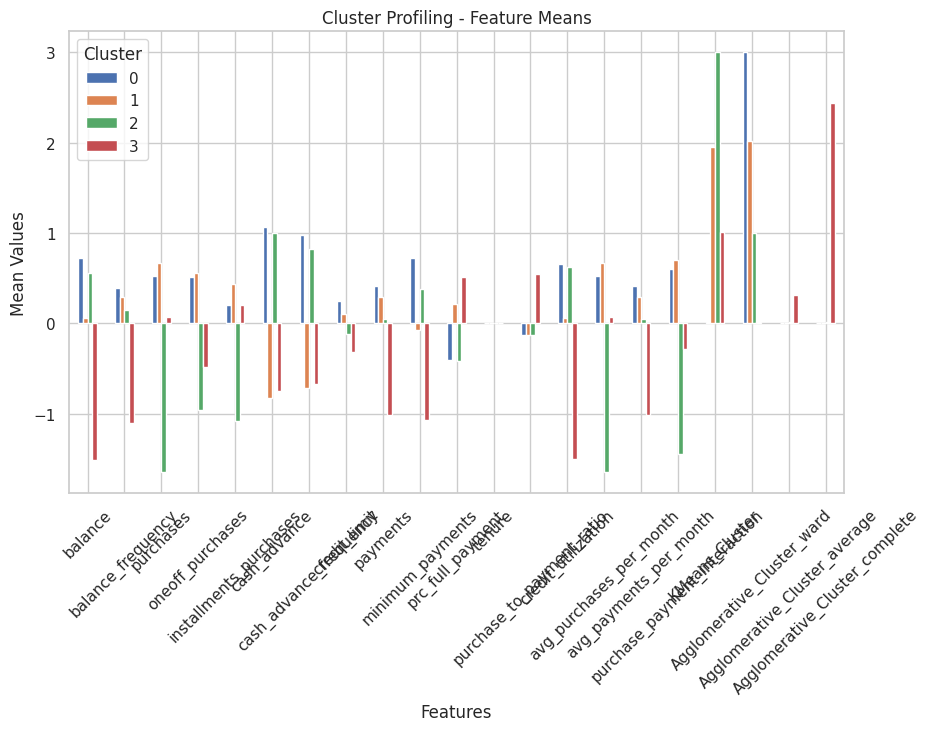

In [65]:
import matplotlib.pyplot as plt

# Transpose the profile data for easier plotting
cluster_profile_T = cluster_profile.T

# List of columns to exclude
columns_to_exclude = [
    'KMeans_Cluster',
    'Agglomerative_Cluster_ward',
    'Agglomerative_Cluster_average',
    'Agglomerative_Cluster_complete'
]

# Print the initial DataFrame
print("Initial DataFrame:\n", cluster_profile_T.head())
print("Initial columns:", cluster_profile_T.columns)

# Exclude specified columns
cluster_profile_T = cluster_profile_T.drop(columns=columns_to_exclude, errors='ignore')

# Print shape after exclusion
print("Shape after exclusion:", cluster_profile_T.shape)

# Plotting
cluster_profile_T.plot(kind='bar', figsize=(10, 6))
plt.title('Cluster Profiling - Feature Means')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()


In [62]:
# Detailed profile with mean, median, min, max for key features in KMeans
detailed_kmeans_profile = scaled_df.groupby('KMeans_Cluster').agg({
    'balance': ['mean', 'median', 'min', 'max'],
    'balance_frequency': ['mean', 'median', 'min', 'max'],  # Added feature
    'purchases': ['mean', 'median', 'min', 'max'],
    'oneoff_purchases': ['mean', 'median', 'min', 'max'],
    'installments_purchases': ['mean', 'median', 'min', 'max'],
    'cash_advance': ['mean', 'median', 'min', 'max'],
    'cash_advance_frequency': ['mean', 'median', 'min', 'max'],  # Added feature
    'credit_limit': ['mean', 'median', 'min', 'max'],
    'payments': ['mean', 'median', 'min', 'max'],
    'minimum_payments': ['mean', 'median', 'min', 'max'],  # Added feature
    'prc_full_payment': ['mean', 'median', 'min', 'max'],  # Added feature
    'tenure': ['mean', 'median', 'min', 'max'],  # Added feature
    'purchase_to_payment_ratio': ['mean', 'median', 'min', 'max'],  # Added feature
    'credit_utilization': ['mean', 'median', 'min', 'max'],  # Added feature
    'avg_purchases_per_month': ['mean', 'median', 'min', 'max'],  # Added feature
    'avg_payments_per_month': ['mean', 'median', 'min', 'max'],  # Added feature
    'purchase_payment_interaction': ['mean', 'median', 'min', 'max'],  # Added feature
})

# View the detailed KMeans cluster profile
print("\nDetailed KMeans Cluster Profile:\n", detailed_kmeans_profile)


Detailed KMeans Cluster Profile:
                balance                   balance_frequency                    \
                  mean median   min  max              mean median   min  max   
KMeans_Cluster                                                                 
0                 0.74   0.78 -0.66 1.20              0.40   0.61 -1.90 0.61   
1                -1.47  -1.42 -3.10 1.20             -1.04  -1.90 -1.90 0.61   
2                 0.11   0.16 -2.06 1.20              0.31   0.61 -1.90 0.61   
3                 0.56   0.61 -1.57 1.20              0.15   0.61 -1.90 0.61   

               purchases                    oneoff_purchases               \
                    mean median   min   max             mean median   min   
KMeans_Cluster                                                              
0                   0.53   0.55 -0.66  1.07             0.52   0.80 -1.00   
1                   0.08   0.22 -1.70  1.07            -0.43  -1.00 -1.00   
2                  

# Cluster Profile Summary

## Overall Summary
The clustering analysis identified four distinct customer segments based on credit card usage, revealing insights for marketing strategies and risk management.

## Cluster Profiles

### Cluster 0: High Balance and Moderate Purchases
- **Balance**: 
  - Mean: 0.74 (Effective management)
- **Purchases**: 
  - Mean: 0.53 (Regular utilization)
- **Payments**: 
  - Mean: 0.42 (Reliable)
- **Credit Limit**: 
  - Mean: 0.26 (Stable)
- **Cash Advance**: 
  - Mean: 1.07 (Liquidity needs)

**Interpretation**: Financially stable customers with active usage and reliable payments.

---

### Cluster 1: Low Balance with High Purchases
- **Balance**: 
  - Mean: -1.47 (Poor management)
- **Purchases**: 
  - Mean: 0.08 (Limited usage)
- **Payments**: 
  - Mean: -0.98 (Financial stress)
- **Credit Limit**: 
  - Mean: -0.34 (Need for borrowing)
- **Cash Advance**: 
  - Mean: -0.71 (Minimal reliance)

**Interpretation**: Active spenders facing financial challenges.

---

### Cluster 2: Moderate Balance with Variable Purchases
- **Balance**: 
  - Mean: 0.11 (Inconsistent management)
- **Purchases**: 
  - Mean: 0.69 (Reliance on credit)
- **Payments**: 
  - Mean: 0.32 (Moderate reliability)
- **Credit Limit**: 
  - Mean: 0.13 (Typical behavior)
- **Cash Advance**: 
  - Mean: -0.85 (Limited needs)

**Interpretation**: Mix of financial stability and variable spending habits.

---

### Cluster 3: Balanced Usage with Inconsistent Payments
- **Balance**: 
  - Mean: 0.56 (Stable management)
- **Purchases**: 
  - Mean: -1.65 (Limited usage)
- **Payments**: 
  - Mean: 0.04 (Possible difficulties)
- **Credit Limit**: 
  - Mean: -0.12 (Average access)
- **Cash Advance**: 
  - Mean: 0.99 (Occasional needs)

**Interpretation**: Balanced spending with financial instability affecting payments.

---

## Conclusion
These profiles facilitate tailored marketing strategies and improved risk management, enhancing customer satisfaction and retention.
